## Baseline Type Classfication 

Goal is to build a baseline type classification model using XGBoost with original track-level summary statistics to establish a performance baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   

# Suppress df assignment warning
pd.options.mode.chained_assignment = None  

# Define file paths
ais_tracks_path = '../data/tracks_ais.csv'
radar_tracks_path = '../data/tracks_radar.csv'
radar_detections_path = '../data/detections_radar.csv'
tagged_detections_path = '../data/detections_tagged.csv'
tracks_tagged_path = '../data/tracks_tagged.csv'

ais_tracks = pd.read_csv(ais_tracks_path)
radar_tracks = pd.read_csv(radar_tracks_path)
radar_detections = pd.read_csv(radar_detections_path)
tagged_detections = pd.read_csv(tagged_detections_path)
tracks_tagged = pd.read_csv(tracks_tagged_path)

del ais_tracks_path, radar_tracks_path, radar_detections_path, tagged_detections_path, tracks_tagged_path

#### Use ais tracks & tagged tracks as train/test/val

In [2]:
#Only drops ~1% possibly duplicate tracks
tracks_tagged_no_assoc = tracks_tagged[tracks_tagged['assoc_id'].isna()]

#Extract human labels as 'type_m2' for tagged_tracks
#currently filter out lobster and fishing(non-lobster) boats
tracks_tagged_no_assoc['type_m2'] = 'N/A'
# Create mask for fishing boats (including fishing_c and fishing_r)
fishing_mask = (
    tracks_tagged_no_assoc['notes'].str.contains('fishing', case=False, na=False) | 
    tracks_tagged_no_assoc['notes'].str.contains('lobster', case=False, na=False) | 
    (tracks_tagged_no_assoc['fishing_c'] == 1) | 
    (tracks_tagged_no_assoc['fishing_r'] == 1)
)

tracks_tagged_no_assoc.loc[fishing_mask, 'type_m2'] = 'fishing_boat'

#~90% of the tagged tracks are missing meaningful labels though, drop them
tracks_tagged_no_assoc = tracks_tagged_no_assoc[tracks_tagged_no_assoc['type_m2'] != 'N/A']

common_cols = [col for col in ais_tracks.columns if col in tracks_tagged_no_assoc.columns]
combined_tracks_with_labels = pd.concat([ais_tracks[common_cols], tracks_tagged_no_assoc[common_cols]], axis=0)

#Use raw track-level summary statistics as features
features_subset = ['min_speed', 'max_speed', 'avg_speed', 'curviness', 'heading_mean', 'heading_std', 
 'turning_mean', 'turning_std', 'duration_z', 'distance', 'distance_o']

#### Aggregate Types from EDA insights

In [3]:
#Examine original types
combined_tracks_with_labels['type_m2'].value_counts()

type_m2
cargo_ship                 10263
class_b                     4795
passenger_ship              3902
other                       2863
tanker_ship                 1411
tug                         1176
military_ship                951
towing_ship                  779
pleasure_craft               557
fishing_boat                 506
commercial_fishing_boat      292
search_and_rescue_boat       178
unknown                       82
sailboat                      70
law_enforcement_boat          55
high_speed_craft              40
pilot_boat                     2
Name: count, dtype: int64

In [4]:
from utilities import VesselTypeAggregator

aggregator = VesselTypeAggregator()
aggregator.aggregate_vessel_type(combined_tracks_with_labels)

combined_tracks_with_labels['type_m2_agg'].value_counts()

type_m2_agg
cargo/tanker      11674
class_b            4795
passenger_ship     3902
other              3220
tug/tow            1955
military_ship       951
fishing_boat        798
pleasure_craft      627
Name: count, dtype: int64

#### XGBoost for 8-class type classification

Baseline 

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
X = combined_tracks_with_labels[features_subset]
y = combined_tracks_with_labels['type_m2_agg']

#Type to number mapping
ship2num, num2ship = {}, {}
num = 0
for vessel in y.unique():
    ship2num[vessel] = num
    num2ship[num] = vessel
    num += 1
y_numeric = y.map(ship2num)

# Train-test split (80:20), stratified sampling by vessel type
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if you want probability outputs
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter tuning (after a few tries)
param_grid = {
    'max_depth': [7, 9, 11],
    'learning_rate': [0.3, 0.5, 0.7],
    'n_estimators': [200, 300, 400]
}

# Perform 4-fold cross-validation with grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)


grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.3, 'max_depth': 11, 'n_estimators': 400}
Best cross-validation accuracy: 0.8388

Test Set Accuracy: 0.8501


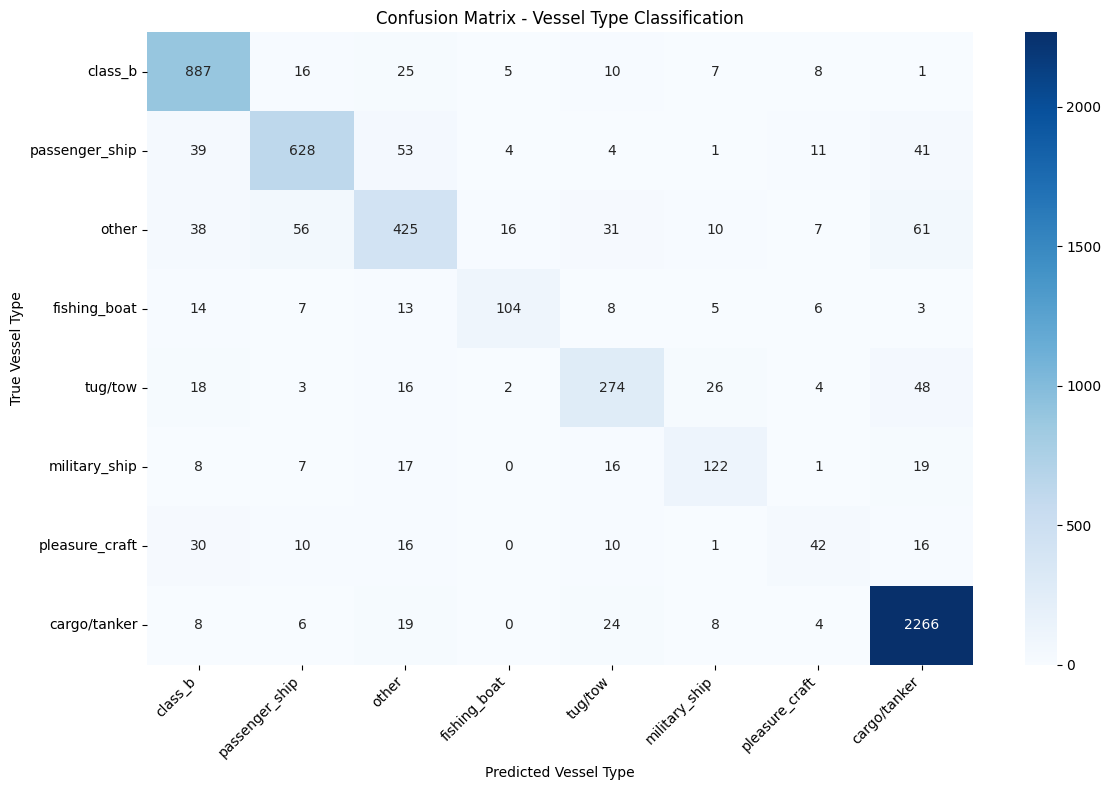

In [9]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(ship2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(ship2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Print classification report for detailed metrics
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=list(ship2num.keys())))

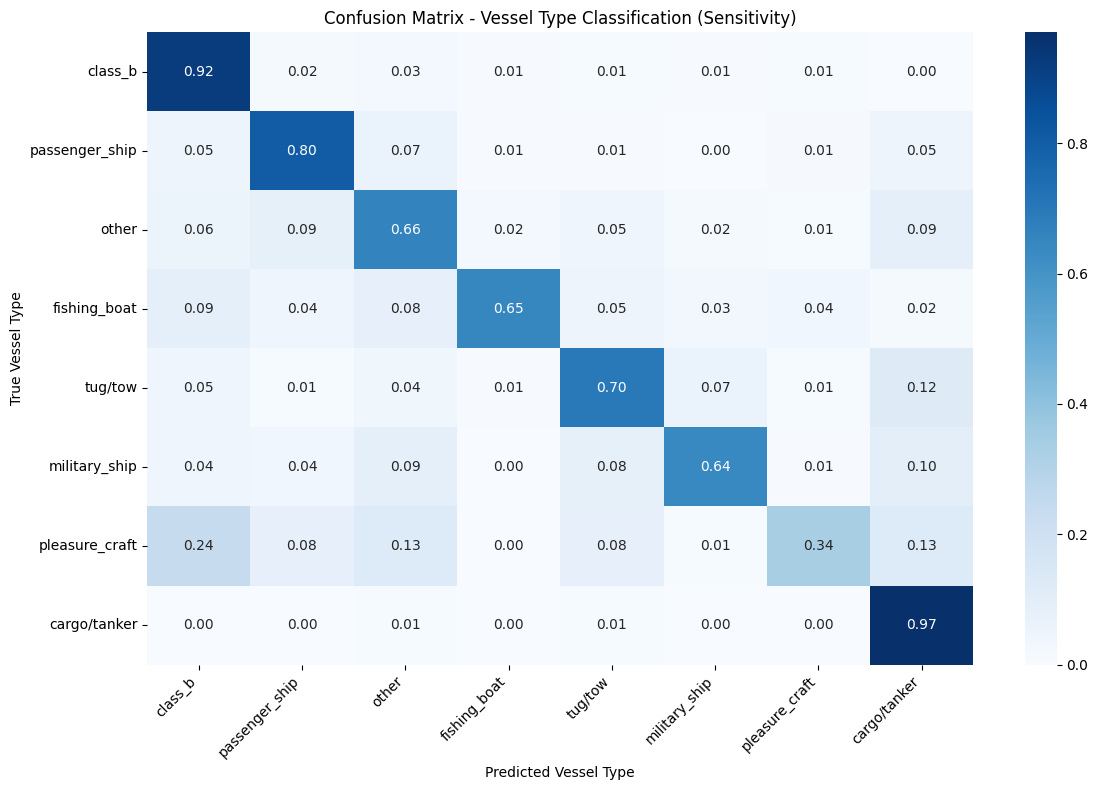

In [10]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall) for each class
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create a matrix where each row is normalized by the sum of that row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create heatmap of normalized confusion matrix
sns.heatmap(cm_normalized, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format as percentages
            cmap='Blues',  # Use blue color scheme
            xticklabels=y.unique(),  # Use vessel type names for x-axis
            yticklabels=y.unique())  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification (Sensitivity)')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

<Figure size 1000x800 with 0 Axes>

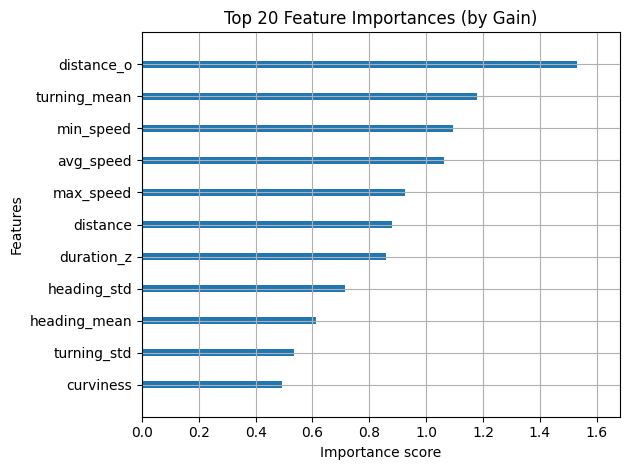

In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Top 20 Feature Importances (by Gain)')
plt.tight_layout()
plt.show()
